In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
DATA_QBITS = 16
LATENT_QBITS = 4
TOTAL_QBITS = DATA_QBITS

INPUT_DATA_SIZE = 9 # image width

DRCs = 1

### data 

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [5]:
x_train = x_train.reshape((x_train.shape[0],28,28,1))
x_test = x_test.reshape((x_test.shape[0],28,28,1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],28,28,1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],28,28,1))

In [6]:
SCALING = 20

x_train_small = tf.image.resize(x_train, (SCALING,SCALING)).numpy()
x_test_small = tf.image.resize(x_test, (SCALING,SCALING)).numpy()

x_train_3_small = tf.image.resize(x_train_threes, (SCALING,SCALING)).numpy()
x_test_3_small = tf.image.resize(x_test_threes, (SCALING,SCALING)).numpy()

2022-08-25 11:53:01.871762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 11:53:01.878006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 11:53:01.878453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 11:53:01.879490: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### circuit

In [7]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [8]:
def single_upload(params, data, wire):
    for i, d in enumerate(tf.reshape(data, [-1])):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))*len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
        for x in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
    #for y in range(0, INPUT_DATA_SIZE ** 2, stride ** 2):
    #    single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
    #                  img[y:y+stride**2], wires[wire])
    #    upload_counter = upload_counter + 1
    #    wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(inputs, weights):
    #inputs = inputs.numpy()
    kernel_size = 3
    stride = 2
    #print(weights)
    #print(inputs)
    #inputs = inputs.reshape(INPUT_DATA_SIZE, INPUT_DATA_SIZE)
    #print(inputs.shape)
    inputs = tf.reshape(inputs, [INPUT_DATA_SIZE, INPUT_DATA_SIZE])
    
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(weights[i*num_upload_params:(i+1)*num_upload_params], inputs, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    return [qml.expval(qml.PauliZ(i)) for i in range(TOTAL_QBITS)]

In [9]:
data = np.random.rand(INPUT_DATA_SIZE*INPUT_DATA_SIZE)

kernel_size = 3
stride = 2
number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

/home/tom/miniconda3/envs/tfqf/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


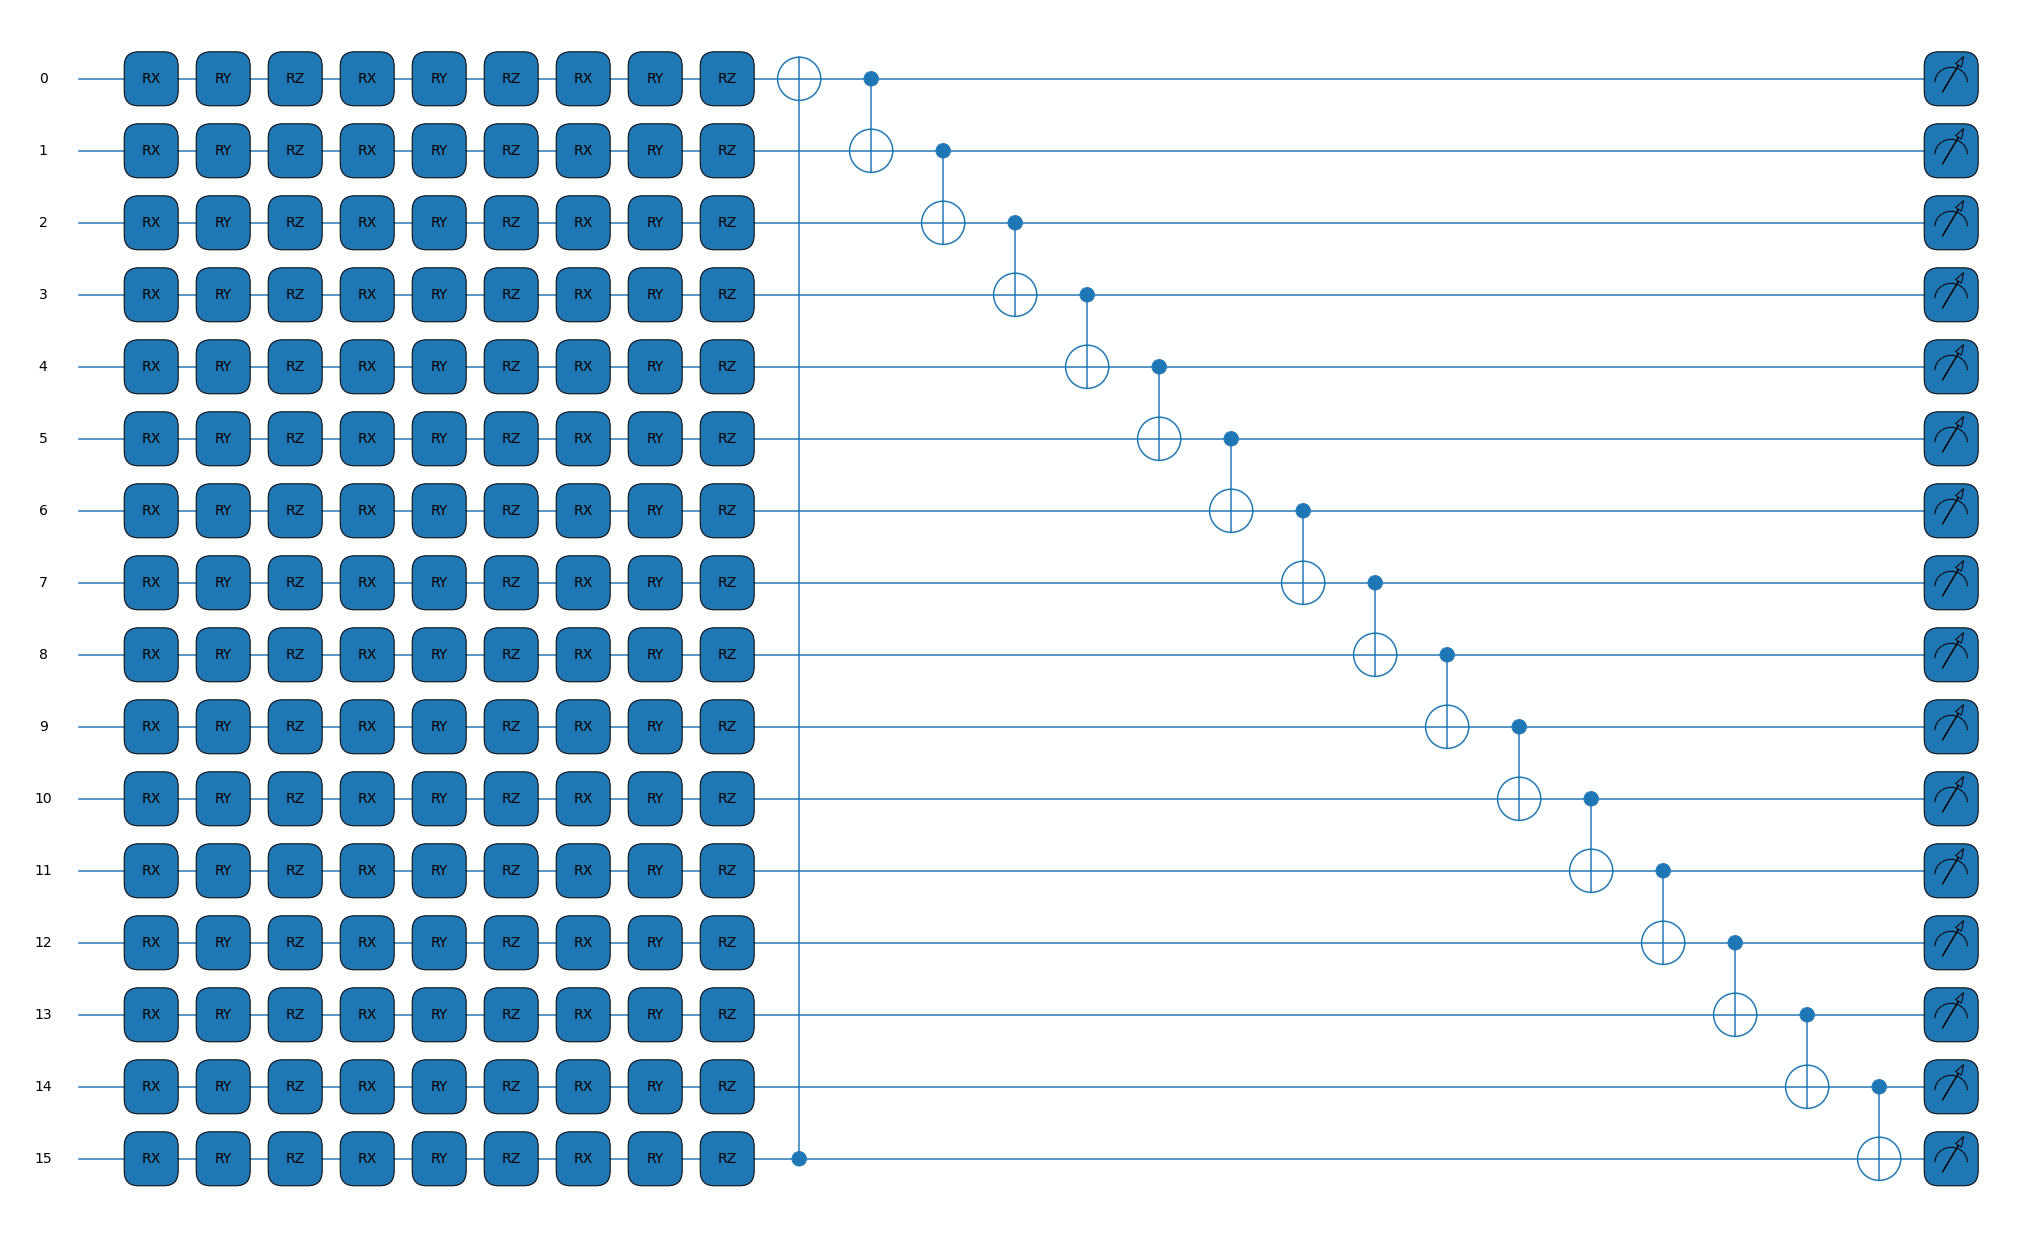

In [10]:
fig, ax = qml.draw_mpl(circuit)(data,np.ones(DRCs*num_upload_params))
fig.show()

In [11]:
weight_shapes = {"weights": (DRCs*num_upload_params,)}

In [12]:
qlayer = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=TOTAL_QBITS)

### hybrid

In [13]:
inputs = tf.keras.layers.Input(shape=(20,20,1))
clayer_1 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='valid', activation="relu")
clayer_2 = tf.keras.layers.Conv2D(10, 2, strides=1, padding='same', activation="relu")
clayer_2 = tf.keras.layers.Conv2D(1, 2, strides=1, padding='same', activation="relu")
dress1 = tf.keras.layers.Flatten()

#dress1 = tf.keras.layers.Reshape((9*9,))
dress2 = tf.keras.layers.Dense(81)
re = tf.keras.layers.Reshape((9,9,1))
clayer_3 = tf.keras.layers.Conv2DTranspose(10, 4, strides=2, padding='valid', activation="relu")
clayer_4 = tf.keras.layers.Conv2DTranspose(10, 2, strides=1, padding='same', activation="relu")
out_layer = tf.keras.layers.Conv2D(1, 2, strides=1, padding='same', activation="sigmoid")

In [14]:
model = tf.keras.models.Sequential([inputs, clayer_1, clayer_2, dress1, qlayer, dress2, re, clayer_3, clayer_4, out_layer])

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss="bce")

In [16]:
model.build(input_shape=(20,20,1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 10)          100       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 16)                0 (unused)
                                                                 
 dense (Dense)               (None, 81)                1377      
                                                                 
 reshape (Reshape)           (None, 9, 9, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 10)       1

In [18]:
print(x_train_small.shape)
print(x_test_small.shape)

print(x_train_3_small.shape)
print(x_test_3_small.shape)

(5918, 20, 20, 1)
(958, 20, 20, 1)
(6131, 20, 20, 1)
(1010, 20, 20, 1)


In [19]:
x_train_small = x_train_small[:4000]
x_test_small = x_test_small[:900]

x_train_3_small = x_train_3_small[:4000]
x_test_3_small = x_test_3_small[:900]

In [20]:
y_train_small = np.ones(x_train_small.shape[0])
y_test_small = np.ones(x_test_small.shape[0])

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.0001)
fitting = model.fit(x_train_small, x_train_small, epochs=20, batch_size=50, steps_per_epoch=50, validation_data=(x_test_small, x_test_small))

Epoch 1/20


2022-08-25 11:53:04.091097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-08-25 11:53:04.422939: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-25 11:53:04.423593: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-25 11:53:04.423609: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-25 11:53:04.424163: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-25 11:53:04.424214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


50/50 [==============================] - 1358s 27s/step - loss: 0.2969 - val_loss: 0.2434
Epoch 2/20
50/50 [==============================] - 1383s 28s/step - loss: 0.2268 - val_loss: 0.2244
Epoch 3/20
50/50 [==============================] - 1269s 25s/step - loss: 0.2104 - val_loss: 0.2092
Epoch 4/20
50/50 [==============================] - 1231s 25s/step - loss: 0.1994 - val_loss: 0.1977
Epoch 5/20
50/50 [==============================] - 1227s 25s/step - loss: 0.1894 - val_loss: 0.1876
Epoch 6/20
50/50 [==============================] - 1226s 25s/step - loss: 0.1789 - val_loss: 0.1786
Epoch 7/20
50/50 [==============================] - 1237s 25s/step - loss: 0.1726 - val_loss: 0.1740
Epoch 8/20
50/50 [==============================] - 1228s 25s/step - loss: 0.1681 - val_loss: 0.1693
Epoch 9/20
50/50 [==============================] - 1227s 25s/step - loss: 0.1632 - val_loss: 0.1612
Epoch 10/20
50/50 [==============================] - 1229s 25s/step - loss: 0.1589 - val_loss: 0.1597


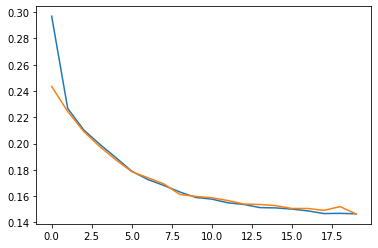

In [22]:
import matplotlib.pyplot as plt
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 10)          100       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 16)                288       
                                                                 
 dense (Dense)               (None, 81)                1377      
                                                                 
 reshape (Reshape)           (None, 9, 9, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 10)       1

Collapse_metric: 0.805
Average EMD: 48.6
ssim: 0.803
MAE: 0.0526
normalized MAE: 0.00091


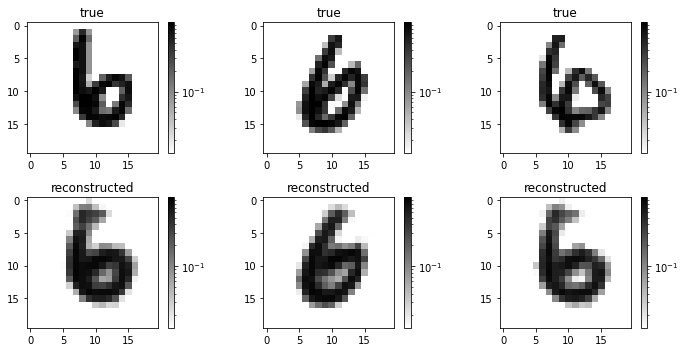

In [24]:
from hep_VQAE import utils as ut

recon = model.predict(x_test_small)

ut.eval_recon(x_test_small, recon, lognorm=True)

Median background: 0.14
Median signal: 0.344
Maximum accuracy: 0.973
AUC: 0.996


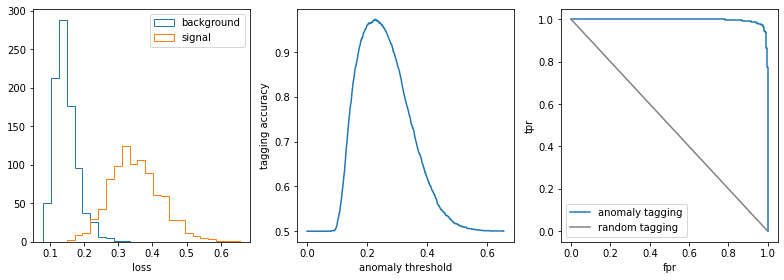

In [25]:
recon = model.predict(x_test_small)
recon_1 = model.predict(x_test_3_small)

ut.eval_tagging(x_test_small, recon, x_test_3_small, recon_1)

Collapse_metric: 0.725
Average EMD: 1.43e+02
ssim: 0.306
MAE: 0.123
normalized MAE: 0.00216


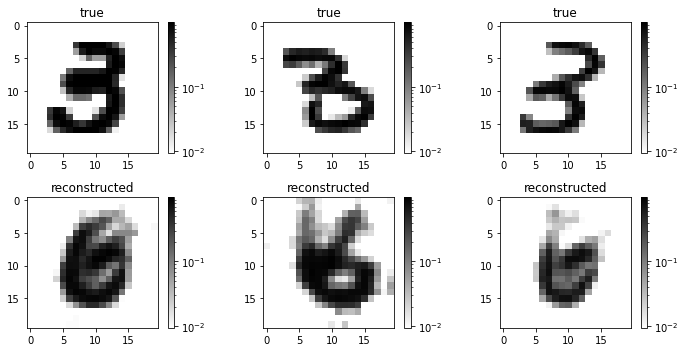

In [26]:
ut.eval_recon(x_test_3_small, recon_1, lognorm=True)